# 9.LightGBM

#### Import packages

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

import lightgbm as lgb

#### set directories

In [2]:
print(os.getcwd())
dirRawData = "../RawData/"
dirPData = "../PData/"
dirPOutput = "../POutput/"

C:\Users\munch\Documents\Cass MSc\Term 3\Machine Learning\Coursework\PCode


#### Load Data

In [3]:
df_train = pd.read_csv(dirRawData + 'train.csv')
df_test = pd.read_csv(dirRawData + 'test.csv')
type(df_train)

pandas.core.frame.DataFrame

In [4]:
f_name = dirPData + '01_df_all.pickle'

with (open(f_name, "rb")) as f:
    dict_ = pickle.load(f)

    
vars_ind_num = dict_['vars_ind_num']
vars_ind_categorical = dict_['vars_ind_categorical']
df_all = dict_['df_all']

del f_name, dict_

In [5]:
f_name = dirPData + '02_vars.pickle'
with open(f_name, "rb") as f:
    dict_ = pickle.load(f)
    
vars_ind_num = dict_['vars_ind_num']
var_dep = dict_['var_dep']
vars_ind_categorical = dict_['vars_ind_categorical']
vars_ind_onehot = dict_['vars_ind_onehot']

del f_name, dict_

#### Set functions

In [10]:
def fn_MAE(actuals, predictions):
    return (np.mean(np.abs(predictions - actuals)))

def fn_RMSE(actuals, predictions):
    return np.round(np.sqrt(np.mean((predictions - actuals)**2)))

#### split data into training, validation and test folds

In [11]:
#split train data into 10 folds (0 to 9)
rng = np.random.RandomState(2018)
fold = rng.randint(0,10,df_train.shape[0])
df_train.loc[:,'fold']= fold

#let df_test_onehot have fold column with value 10
df_test.loc[:,'fold']= 10

#add back train and test dataframe to form a new df_all_onehot
df_all = pd.concat([df_train, df_test],ignore_index = True, sort =False)   #now df_all has folds

In [12]:
idx_train  = df_all['fold'].isin(range(9))
idx_val    = df_all['fold'].isin([9])
idx_design = df_all['fold'].isin(range(10))
idx_test   = df_all['fold'].isin([10])

y = df_all[var_dep].values.ravel()
y_train = y[idx_train]
y_val = y[idx_val]
y_design = y[idx_design]
y_test = y[idx_test]

In [13]:
vars_ind = vars_ind_categorical + vars_ind_num

In [14]:
df_all[vars_ind_categorical].head()

,v_char_1,v_char_2,v_char_3,v_char_4,v_char_5,v_char_6,v_char_7,v_char_8,v_char_9,v_char_10,...,v_char_114,v_char_115,v_char_116,v_char_117,v_char_118,v_char_119,v_char_120,v_char_121,v_char_122,v_char_123
0,G,V,q,S,Q,K,Q,d,Y,V,...,D,p,n,s,a,z,q,j,W,n
1,G,I,q,S,Q,i,Q,d,I,p,...,D,F,n,s,d,z,q,j,W,n
2,G,I,L,S,Q,L,Q,h,I,p,...,D,F,n,s,d,z,q,j,W,n
3,G,I,q,S,Q,i,Q,h,I,p,...,D,F,n,s,d,z,q,j,W,n
4,G,V,q,S,Q,i,Q,d,Y,V,...,D,p,n,s,P,z,q,j,W,n


#### One hot variables 

In [15]:
from sklearn import preprocessing

for col in vars_ind_categorical:
    le = preprocessing.LabelEncoder()
    le.fit(df_all[col].values)
    df_all[col] = le.transform(df_all[col].values)

In [16]:
df_X_train  = df_all[idx_train][vars_ind]
df_X_val    = df_all[idx_val][vars_ind]
df_X_design = df_all[idx_design][vars_ind]
df_X_test   = df_all[idx_test][vars_ind]
df_X_all    = df_all[vars_ind]

## Start lightgbm

In [17]:
d_train  = lgb.Dataset(df_X_train,
                       label=y_train,
                       feature_name=vars_ind,
                       categorical_feature=vars_ind_categorical,
                       free_raw_data=False)

d_val    = lgb.Dataset(df_X_val,
                       label=y_val,
                       feature_name=vars_ind,
                       categorical_feature=vars_ind_categorical,
                       free_raw_data=False)

d_design = lgb.Dataset(df_X_design,
                       label=y_design,
                       feature_name=vars_ind,
                       categorical_feature=vars_ind_categorical,
                       free_raw_data=False)

d_test   = lgb.Dataset(df_X_test,
                       label=y_test,
                       feature_name=vars_ind,
                       categorical_feature=vars_ind_categorical,
                       free_raw_data=False)

d_all    = lgb.Dataset(df_X_all,
                       feature_name=vars_ind,
                       categorical_feature=vars_ind_categorical,
                       free_raw_data=False)

In [18]:
#params = {
   #   "boosting_type": "gbrt"
   # , "objective": "Binary"
  #  , "metric": "auc"
   # , "learning_rate" : 0.058
  #  , "max_depth" :5
  #  , "num_leaves": 50
  #  , "subsample" : 0.7
  #  , "colsample_bytree" : 0.9
 #  , "min_data_in_leaf" : 10
 #   , "bagging_seed": 2018
  #  , "score_tree_interval": 100
#}

params = {
      "boosting_type": "gbrt"
    , "objective": "Binary"
    , "metric": "auc"
    , "learning_rate" : 0.058
    , "max_depth" :5
    , "num_leaves": 50
    , "subsample" : 0.7
    , "colsample_bytree" : 0.9
    , "min_data_in_leaf" : 10
    , "bagging_seed": 2018
    , "score_tree_interval": 100
}


In [19]:
num_boost_round = 6000
early_stopping_rounds = 20

model = lgb.train(params, 
                d_train,
                num_boost_round = num_boost_round,
                valid_sets=[d_val],
                early_stopping_rounds = early_stopping_rounds,
                verbose_eval=500)

C:\Users\munch\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\munch\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[96]	valid_0's auc: 0.888506


In [20]:
pred_train = model.predict(df_X_train, num_iteration=model.best_iteration)
pred_val   = model.predict(df_X_val, num_iteration=model.best_iteration)

In [21]:
from sklearn.metrics import roc_auc_score
auc_train = roc_auc_score(y_train,pred_train)
auc_val = roc_auc_score(y_val,pred_val)
print("train auc: {}".format(auc_train))
print("val auc: {}".format(auc_val))

train auc: 0.9700177480776891
val auc: 0.8885056739073065


In [22]:
pred_test=model.predict(df_X_test, num_iteration=model.best_iteration)

#### Interpertability 

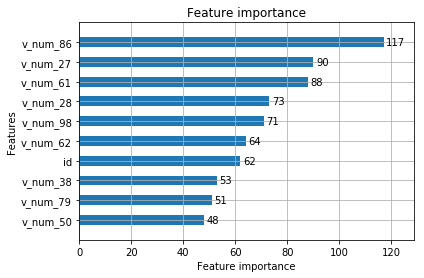

In [23]:
lgb.plot_importance( model, ax=None, height=0.5, xlim=None, ylim=None, 
    title='Feature importance', xlabel='Feature importance', ylabel='Features',
    importance_type='split', max_num_features=10, ignore_zero=True, 
    figsize=None, grid=True)

# show the importance of feature 


Beacuse the model above did not have a high score in Kaggle, we try to use gridsearch. Successfully, we got a better score 

## Gridserch to finf the best model and fit it

In [24]:
from sklearn.model_selection import GridSearchCV

#params = {
      "boosting_type": "gbrt"
    , "objective": "Binary"
    , "metric": "auc"
    , "num_leaves": 50
    , "subsample" : 0.7
    , "colsample_bytree" : 0.9
    , "bagging_seed": 2018
    , "score_tree_interval": 100
}


In [25]:
lgb_estimator =lgb.LGBMClassifier(boosting_type='gbdt',  objective='binary')

In [26]:
param_grid ={ 'learning_rate' :[0.0575,0.058,0.06],
              'max_depth' :[5],
               'min_data_in_leaf': [30,25]
}

In [27]:
gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=10)

In [28]:
lgb_model = gsearch.fit(X=df_X_train,y=y_train )

In [29]:
#print the Best parameters fot the result of gridsearch
print(lgb_model.best_params_, lgb_model.best_score_)

{'learning_rate': 0.0575, 'max_depth': 5, 'min_data_in_leaf': 25} 0.9225157000369413


In [30]:
pred_test=lgb_model.predict_proba(df_X_test)

#### Save predited data for test

In [31]:
lightgbm=pred_test[:,1]
lightgbm

array([0.03622958, 0.24963891, 0.02920332, ..., 0.1474256 , 0.02664611,
       0.79343669])

In [32]:
import csv
f_name = dirPOutput + 'lightgbmbinary7.csv'

df_test = pd.read_csv(dirRawData + 'test.csv')

with open(f_name, 'w',newline='') as csvfile:
    writer=csv.writer(csvfile,delimiter=',')
    writer.writerow(["id", "target"])
    writer.writerows(zip(df_test[df_test.columns[0]], lightgbm))

In [33]:
pred_design=lgb_model.predict_proba(df_X_design)

In [34]:
lightgbdesign=pred_design[:,1]

In [39]:
#save data

dict_ = {'lgbm_prob_design': lightgbdesign,
        'lgbm_prob_test' : lightgbm}

f_name = dirPData + 'lgbm.pickle'
with open(f_name, "wb") as f:
    pickle.dump(dict_, f)
del f_name